<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fbase-models/models/base_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil
import time
import psutil

# Regenerar el código con las condiciones específicas
notebook_globals = {
    "USE_CROSS_VALIDATION": False,
    "ENABLED_MODELS": ['CNN', 'GRU'],
    "ENABLED_EXPERIMENTS": ['time+cycles', 'all_features'],
    "ENABLED_HORIZONS": [3],
}

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
data_output_dir = BASE_PATH / 'data' / 'output'
model_output_dir = BASE_PATH / 'models' / 'output'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'ml_precipitation_prediction' already exists and is not an empty directory.
/content/ml_precipitation_prediction
Entorno configurado. Usando ruta base: /content/drive/MyDrive/ml_precipitation_prediction


In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input
import traceback

# ==== Variables de control ====
USE_CROSS_VALIDATION = False
ENABLED_MODELS = ['CNN'] # Primer ronda ENABLED_MODELS = ['CNN', 'GRU'], segunda ronda: ENABLED_MODELS = ['LSTM', 'BLSTM']
ENABLED_EXPERIMENTS = ['time+cycles', 'time+cycles+elev', 'time+cycles+elev+cluster']
ENABLED_HORIZONS = [3]
INPUT_WINDOW = 60  # 5 años (mensual)
OUTPUT_HORIZON = 3

# ==== Configuración de entorno ====
print("🔍 Detectando dispositivo disponible...")
gpu_devices = tf.config.list_physical_devices('GPU')
USE_GPU = bool(gpu_devices)
if USE_GPU:
    print("✅ GPU detectada:", gpu_devices[0].name)
    print("ℹ️ Entrenamiento acelerado con GPU activado.")
else:
    print("⚠️ No se detectó GPU. Usando CPU.")

# ==== Funciones auxiliares ====
def build_model(model_type, input_shape, output_neurons):
    model = Sequential()
    model.add(Input(shape=input_shape, dtype='float32'))
    if model_type == 'LSTM':
        model.add(LSTM(64))
    elif model_type == 'GRU':
        model.add(GRU(64))
    elif model_type == 'BLSTM':
        model.add(Bidirectional(LSTM(64)))
    elif model_type == 'CNN':
        model.add(Reshape((*input_shape, 1)))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(GlobalAveragePooling2D())
    model.add(Dense(output_neurons, activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=16):
        self.x, self.y = x_set.astype(np.float32), y_set.astype(np.float32)
        self.batch_size = batch_size
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def to_dataset(x, y):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    return tf.data.Dataset.from_tensor_slices((x, y)).batch(16).prefetch(tf.data.AUTOTUNE)

# ==== Directorios y Dataset ====
print("📂 Configurando directorios y cargando dataset...")
try:
    model_output_dir_STH = model_output_dir / 'ST_HybridWaveStack'
    curves_dir = model_output_dir_STH / "learning_curves"
    if not model_output_dir_STH.exists():
        model_output_dir_STH.mkdir(parents=True, exist_ok=True)
    if not curves_dir.exists():
        curves_dir.mkdir(parents=True, exist_ok=True)
    print(f"✔️ Modelos en: {model_output_dir_STH}")
    print(f"✔️ Curvas en: {curves_dir}")

    file_path = data_output_dir / "complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
    ds = xr.open_dataset(file_path)
    print(f"✔️ Dataset cargado desde: {file_path}")
except Exception as e:
    raise RuntimeError(f"❌ Error cargando dataset o creando carpetas: {e}")

# ==== Configuración de experimentos ====
experiment_settings = {
    "time+cycles": ['year','month',
                    'month_sin','month_cos','doy_sin','doy_cos'],
    "time+cycles+lag":  ['year','month',
                        'month_sin','month_cos','doy_sin','doy_cos',
                        'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                        'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+lag+elev": ['year','month',
                             'month_sin','month_cos','doy_sin','doy_cos',
                            'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                            'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                            'elevation','slope','aspect'],
    "time+cycles+elev":   ['year','month',
                          'month_sin','month_cos','doy_sin','doy_cos',
                          'elevation','slope','aspect'],
    "time+cycles+elev+cluster":   ['year','month',
                                  'month_sin','month_cos','doy_sin','doy_cos',
                                  'elevation','slope','aspect',
                                  'cluster_elevation'],
    "all_features": ['year','month',
                     'month_sin','month_cos','doy_sin','doy_cos',
                    'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                    'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                    'elevation','slope','aspect',
                     'cluster_elevation']
}

# Validación de variables
ds_vars = set(ds.data_vars)
for name, vars_list in experiment_settings.items():
    missing = [v for v in vars_list if v not in ds_vars]
    if missing:
        raise ValueError(f"❌ Faltan vars para '{name}': {missing}")
print("✅ Variables requeridas presentes.")

results = []

# ==== Entrenamiento modular ====
for exp_name, variables in experiment_settings.items():
    if exp_name not in ENABLED_EXPERIMENTS:
        continue
    try:
        cluster_idx = variables.index('cluster_elevation') if 'cluster_elevation' in variables else None
        subset = ds[variables].to_array().transpose('time','latitude','longitude','variable').values
        if cluster_idx is not None:
            subset[..., cluster_idx] = LabelEncoder().fit_transform(subset[..., cluster_idx].ravel()).reshape(subset[..., cluster_idx].shape)
        subset = subset.astype(np.float32)
        target = ds['total_precipitation'].values
        samples, lat, lon, feats = subset.shape
        X = subset.reshape(samples, lat*lon, feats)
        y = target.reshape(samples, lat*lon)
        mask = ~np.isnan(y)
        X, y = X[mask], y[mask]

        X_seq, Y_targets = [], []
        for i in range(len(X) - INPUT_WINDOW - OUTPUT_HORIZON):
            X_seq.append(X[i:i + INPUT_WINDOW])
            Y_targets.append([y[i + INPUT_WINDOW + h] for h in range(OUTPUT_HORIZON)])
        X_seq, Y_targets = np.array(X_seq), np.array(Y_targets)

        valid_mask = (~np.isnan(X_seq).any(axis=(1,2))) & (~np.isnan(Y_targets).any(axis=1))
        X_seq, Y_targets = X_seq[valid_mask], Y_targets[valid_mask]
        if len(X_seq) == 0:
            continue

        input_shape = (X_seq.shape[1], X_seq.shape[2])
        for model_name in ENABLED_MODELS:
            split_idx = int(len(X_seq) * 0.7)
            train_idx = np.arange(split_idx)
            val_idx = np.arange(split_idx, len(X_seq))

            X_tr, X_va = X_seq[train_idx], X_seq[val_idx]
            y_tr, y_va = Y_targets[train_idx], Y_targets[val_idx]

            scalerX = StandardScaler()
            X_tr = scalerX.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
            X_va = scalerX.transform(X_va.reshape(-1, X_va.shape[-1])).reshape(X_va.shape)

            scalery = StandardScaler()
            y_tr = scalery.fit_transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)
            y_va = scalery.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)

            train_gen = DataGenerator(X_tr, y_tr, batch_size=16)
            val_gen = DataGenerator(X_va, y_va, batch_size=16)

            model_path = model_output_dir_STH / f"{exp_name.replace('+','_')}_{model_name}_NoCV.h5"
            if model_path.exists():
                continue

            model = build_model(model_name, input_shape, OUTPUT_HORIZON)
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)
            history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=[es])

            y_pred = model.predict(X_va)
            y_true = y_va

            metrics = [evaluate(y_true[:, i], y_pred[:, i]) for i in range(OUTPUT_HORIZON)]

            results.append({
                'experiment': exp_name,
                'model': model_name,
                'horizon': OUTPUT_HORIZON,
                'cv_enabled': USE_CROSS_VALIDATION,
                'RMSE': np.mean([m[0] for m in metrics]),
                'MAE': np.mean([m[1] for m in metrics]),
                'MAPE': np.mean([m[2] for m in metrics]),
                'R2': np.mean([m[3] for m in metrics]),
                'epochs': len(history.history['loss'])
            })

            plt.figure()
            plt.plot(history.history['loss'], label='Train')
            plt.plot(history.history['val_loss'], label='Val')
            plt.title(f'{exp_name} - {model_name} - NoCV')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            fname = f"{exp_name.replace('+','_')}_{model_name}_NoCV.png"
            plt.savefig(curves_dir / fname)
            plt.close()

            model.save(model_path)
    except Exception as e:
        print(f"❌ Error en '{exp_name}': {e}\n{traceback.format_exc()}")

# ==== Guardar resultados ====
results_df = pd.DataFrame(results)
results_df.to_csv("resultados_modelos_cv_8anios_mvp.csv", index=False)

import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados CV MVP", dataframe=results_df)


🔍 Detectando dispositivo disponible...
✅ GPU detectada: /physical_device:GPU:0
ℹ️ Entrenamiento acelerado con GPU activado.
📂 Configurando directorios y cargando dataset...
✔️ Modelos en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack
✔️ Curvas en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/learning_curves
✔️ Dataset cargado desde: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
✅ Variables requeridas presentes.

🚀 Experimento: time+cycles
📉 Secuencias orig.: 2101387, válidas: 2101387, eliminadas: 0 (0.00%)
🔧 Modelo: CNN
⏩ Ya existe. Skip.

🚀 Experimento: time+cycles+elev
📉 Secuencias orig.: 2101387, válidas: 2101387, eliminadas: 0 (0.00%)
🔧 Modelo: CNN
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91936/91936 ━━━━━━━━━━━━━━━━━━━━ 248s 3ms/step - loss: 0.3625 - val_loss: 0.5848
Epoch 2/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.3016 - val_loss: 2.1834
Epoch 3/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2904 - val_loss: 1.3271
Epoch 4/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2879 - val_loss: 3.5862
Epoch 5/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2861 - val_loss: 5.3133
Epoch 6/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2834 - val_loss: 4.6434
Epoch 7/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 244s 3ms/step - loss: 0.2842 - val_loss: 2.2013
Epoch 8/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 244s 3ms/step - loss: 0.2828 - val_loss: 5.0000
Epoch 9/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 242s 3ms/step - loss: 0.2818 - val_loss: 2.8726
Epoch 10/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 241s 3ms/step - loss: 0.2810 - val_loss: 2.7782
19701/19701 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


💾 Modelo guardado: time_cycles_elev_CNN_NoCV.h5

🚀 Experimento: time+cycles+elev+cluster
📉 Secuencias orig.: 2101387, válidas: 2101387, eliminadas: 0 (0.00%)
🔧 Modelo: CNN
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91936/91936 ━━━━━━━━━━━━━━━━━━━━ 247s 3ms/step - loss: 0.3560 - val_loss: 0.5302
Epoch 2/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 245s 3ms/step - loss: 0.3033 - val_loss: 0.8133
Epoch 3/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2968 - val_loss: 0.6821
Epoch 4/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2946 - val_loss: 1.3460
Epoch 5/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 244s 3ms/step - loss: 0.2947 - val_loss: 2.7672
Epoch 6/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 243s 3ms/step - loss: 0.2940 - val_loss: 1.4181
Epoch 7/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 244s 3ms/step - loss: 0.2913 - val_loss: 3.2823
Epoch 8/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 242s 3ms/step - loss: 0.2896 - val_loss: 3.1378
Epoch 9/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 242s 3ms/step - loss: 0.2900 - val_loss: 4.1660
Epoch 10/50
91936/91936 ━━━━━━━━━━━━━━━━━━━━ 245s 3ms/step - loss: 0.2887 - val_loss: 4.2020
19701/19701 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


💾 Modelo guardado: time_cycles_elev_cluster_CNN_NoCV.h5
                 experiment model  horizon  cv_enabled      RMSE       MAE  \
0          time+cycles+elev   CNN        3       False  0.764632  0.614991   
1  time+cycles+elev+cluster   CNN        3       False  0.728120  0.574076   

          MAPE        R2  epochs  
0  1597.669922  0.355946      10  
1  1097.106445  0.416073      10  
Resultados CV MVP


✅ Proceso finalizado con éxito.


📂 Configurando directorios y cargando dataset...
✔️ Modelos encontrados: 6
✔️ Dataset cargado desde: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
🔍 Evaluando modelo: time_cycles_CNN_NoCV.h5


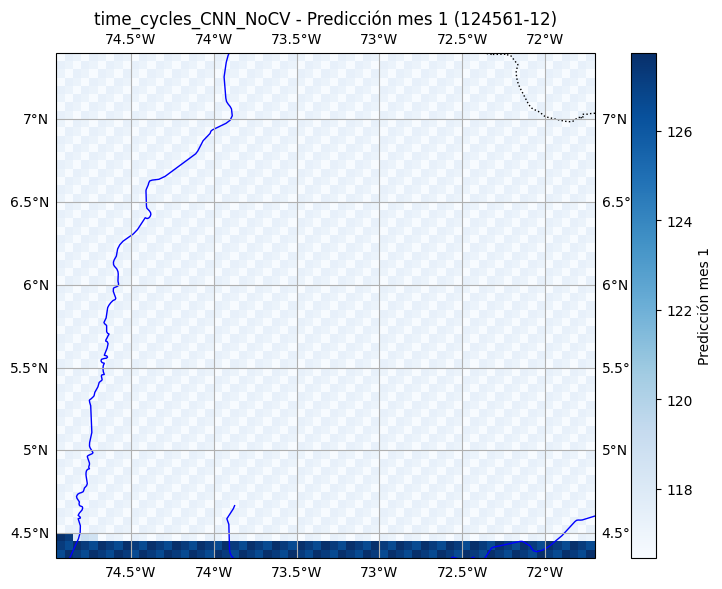

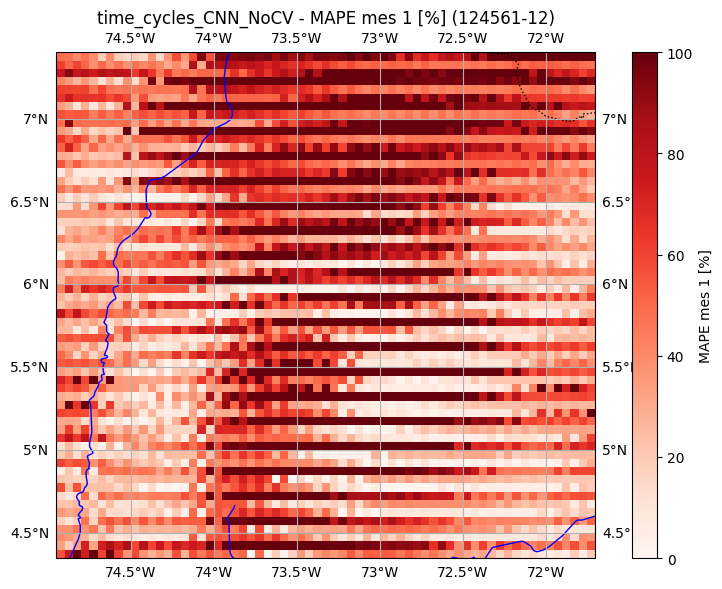

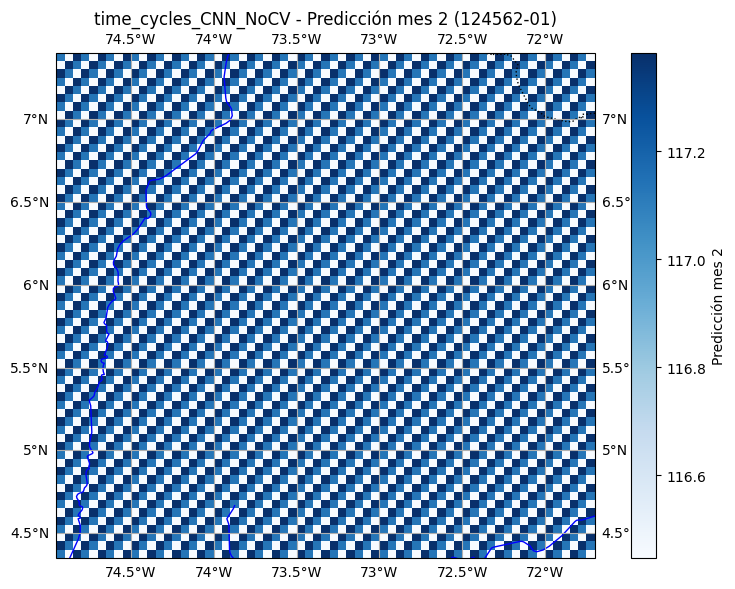

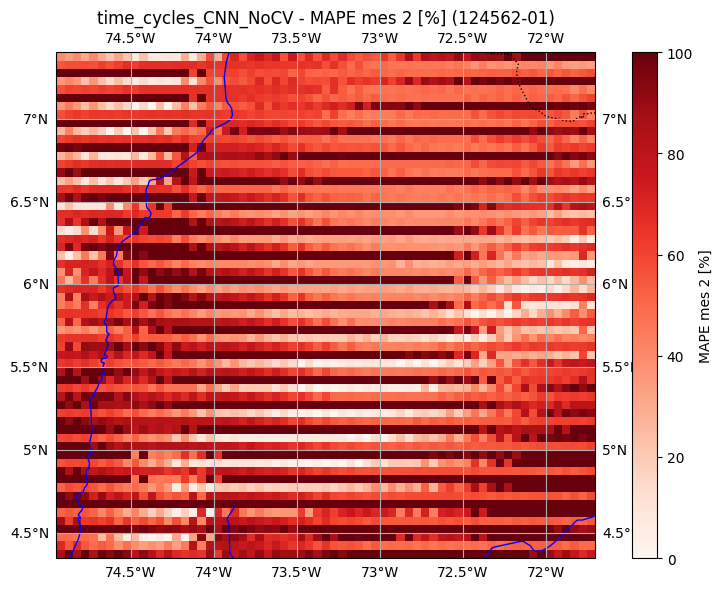

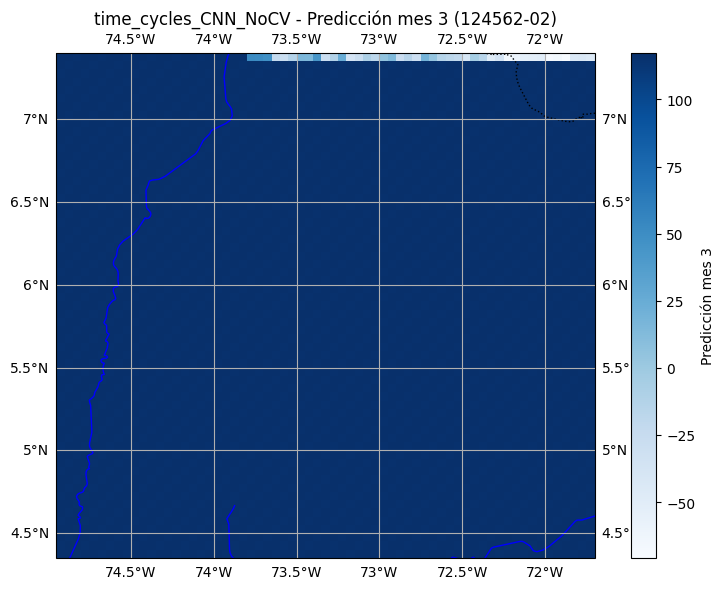

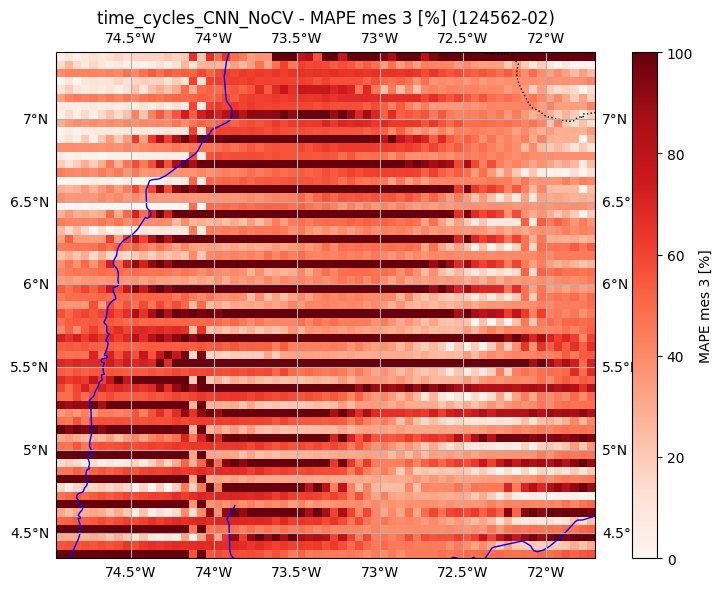

🔍 Evaluando modelo: time_cycles_GRU_NoCV.h5


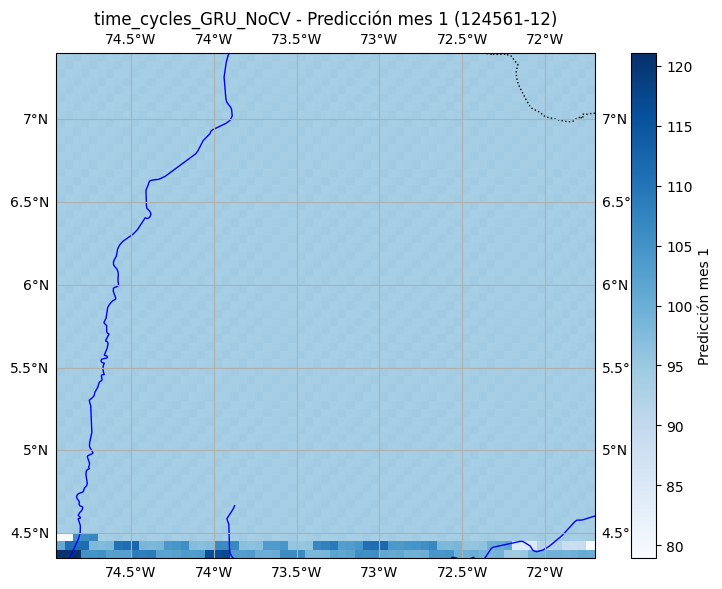

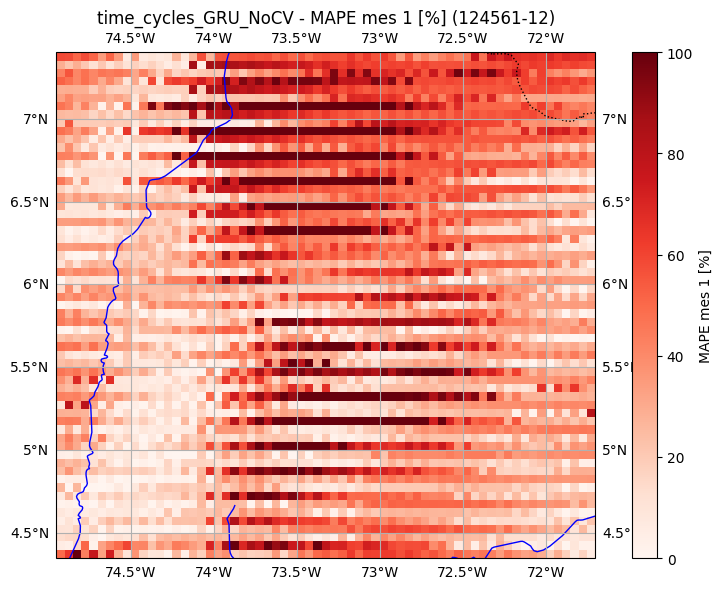

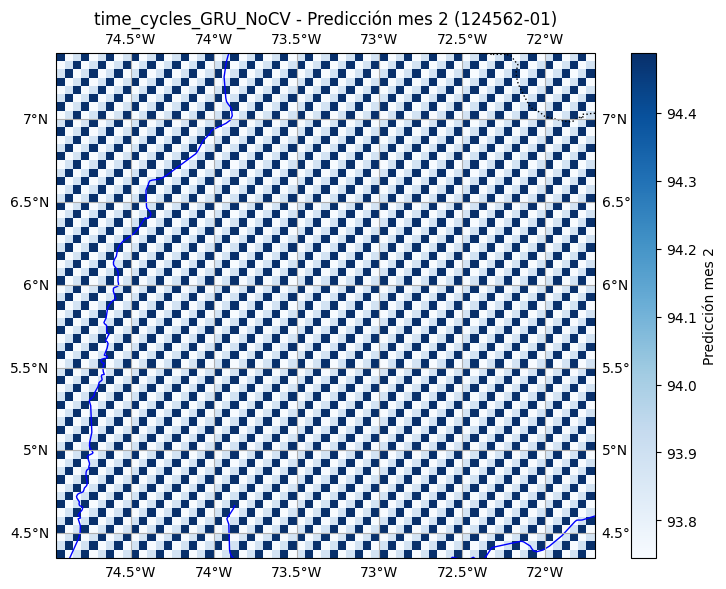

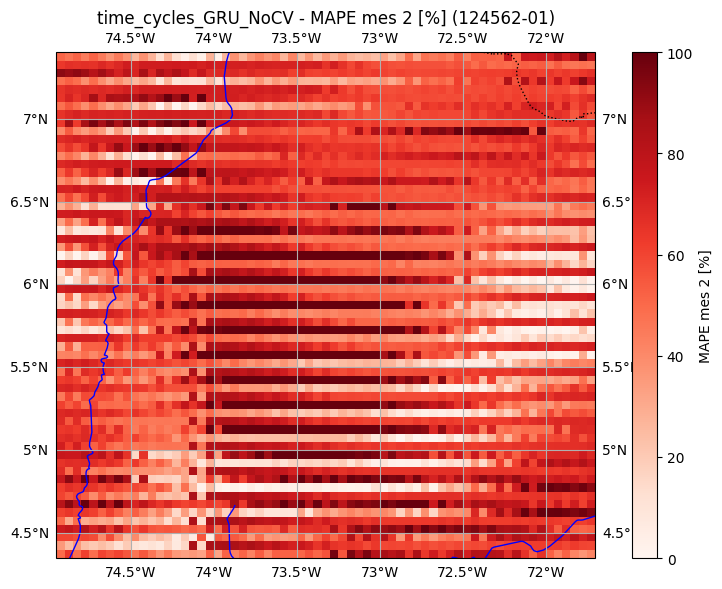

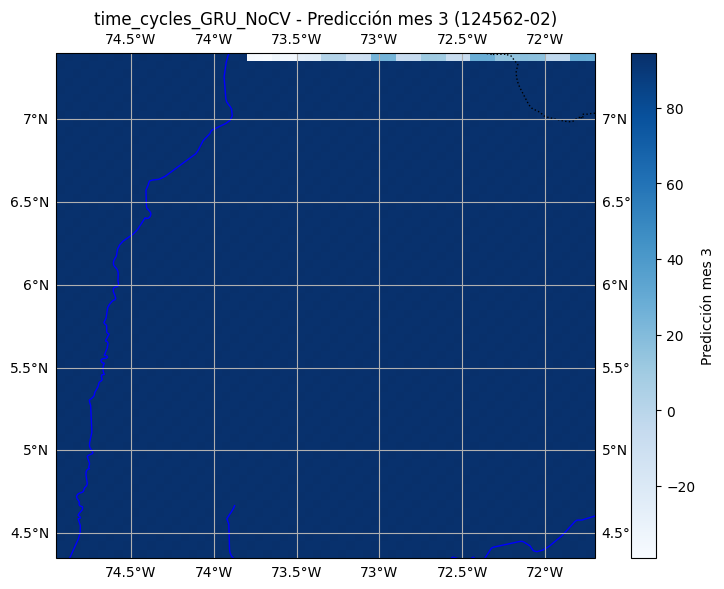

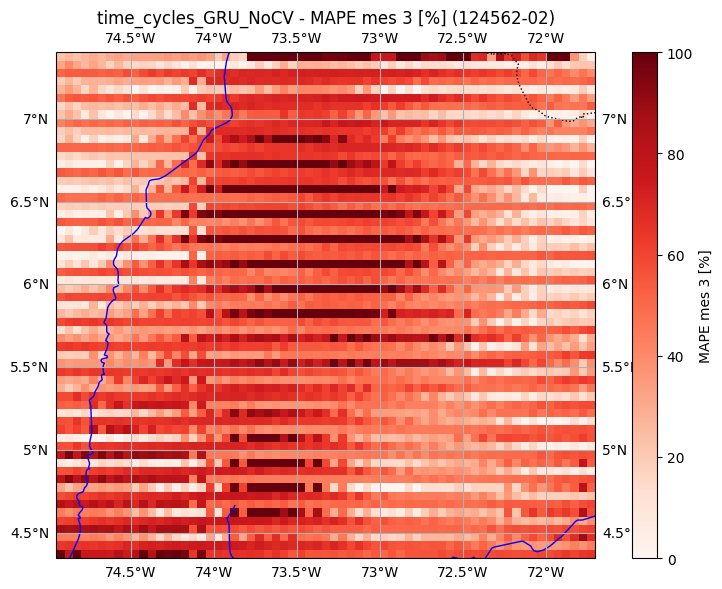

🔍 Evaluando modelo: time_cycles_elev_CNN_NoCV.h5
⚠️ Error de dimensiones: modelo espera 9, pero input tiene 6
🔍 Evaluando modelo: time_cycles_elev_GRU_NoCV.h5
⚠️ Error de dimensiones: modelo espera 9, pero input tiene 6
🔍 Evaluando modelo: time_cycles_elev_cluster_CNN_NoCV.h5
⚠️ Error de dimensiones: modelo espera 10, pero input tiene 6
🔍 Evaluando modelo: time_cycles_elev_cluster_GRU_NoCV.h5
⚠️ Error de dimensiones: modelo espera 10, pero input tiene 6
Resultados Test Mensual


📊 Evaluación finalizada.


In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import traceback


# === CONFIGURACIÓN GENERAL ===
INPUT_WINDOW = 60
HORIZON = 3
TARGET_VAR = 'total_precipitation'
BASE_MODEL_DIR = Path("/content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack")
DATASET_PATH = Path("/content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc")
RESULTS_CSV = BASE_MODEL_DIR / "metrics_modelos_test_completo.csv"

# === MAPEO DE EXPERIMENTOS Y VARIABLES ===
experiment_settings = {
    "time+cycles": ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos'],
    "time+cycles+lag": ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                        'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                        'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+lag+elev": ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                             'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                             'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                             'elevation','slope','aspect'],
    "time+cycles+elev": ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                         'elevation','slope','aspect'],
    "time+cycles+elev+cluster": ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                 'elevation','slope','aspect','cluster_elevation'],
    "all_features": ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                     'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                     'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                     'elevation','slope','aspect','cluster_elevation']
}

# === CARGAR DATASET ===
print("📂 Cargando dataset...")
ds = xr.open_dataset(DATASET_PATH)
latitude = ds.latitude.values
longitude = ds.longitude.values
base_year = int(ds.year[0].values)
base_month = int(ds.month[0].values)
lat_size, lon_size = len(latitude), len(longitude)
n_cells = lat_size * lon_size

# === BUSCAR MODELOS ===
model_files = list(BASE_MODEL_DIR.glob("*.h5"))
print(f"✔️ Modelos encontrados: {len(model_files)}")

# === FUNCIÓN AUXILIAR DE PLOT ===
def plot_map(data, title, cmap, date_label, vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    mesh = ax.pcolormesh(longitude, latitude, data, cmap=cmap,
                         shading='nearest', transform=ccrs.PlateCarree(),
                         vmin=vmin, vmax=vmax)
    plt.colorbar(mesh, ax=ax, orientation='vertical', label=title)
    ax.set_title(f"{title} ({date_label})")
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.LAKES, edgecolor='gray')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.tight_layout()
    plt.show()


# === EVALUACIÓN DE MODELOS ===
results = []

for model_path in model_files:
    model_name = model_path.stem
    print(f"\n🔍 Evaluando modelo: {model_name}")

    # Inferencia del experimento a partir del nombre del archivo
    exp_match = next((k for k in experiment_settings if k.replace("+", "_") in model_name), None)
    if not exp_match:
        print(f"⚠️ No se pudo identificar el experimento para {model_name}")
        continue

    try:
        # Carga de variables para el experimento
        variables = experiment_settings[exp_match]
        data_array = ds[variables].to_array().transpose("time", "latitude", "longitude", "variable").values
        target_array = ds[TARGET_VAR].values

        # Codificar variable categórica si existe
        if 'cluster_elevation' in variables:
            cluster_idx = variables.index('cluster_elevation')
            labeler = LabelEncoder()
            flat = data_array[..., cluster_idx].ravel()
            data_array[..., cluster_idx] = labeler.fit_transform(flat).reshape(data_array[..., cluster_idx].shape)

        # Reestructurar [time, lat, lon, vars] => [time, cells, vars]
        samples, lat, lon, feats = data_array.shape
        X = data_array.reshape(samples, lat * lon, feats)
        y = target_array.reshape(samples, lat * lon)
        mask = ~np.isnan(y)
        X, y = X[mask], y[mask]

        # Crear secuencias de entrada/salida
        X_seq, y_seq = [], []
        for i in range(len(X) - INPUT_WINDOW - HORIZON):
            X_seq.append(X[i:i + INPUT_WINDOW])
            y_seq.append([y[i + INPUT_WINDOW + h] for h in range(HORIZON)])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        # Separar train/test (70/30)
        split = int(len(X_seq) * 0.7)
        X_test, y_test = X_seq[split:], y_seq[split:]

        # Escalar
        sx = StandardScaler()
        sy = StandardScaler()
        X_test_scaled = sx.fit_transform(X_test.reshape(-1, feats)).reshape(X_test.shape)
        y_test_scaled = sy.fit_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

        # Cargar modelo
        model = tf.keras.models.load_model(model_path, compile=False)
        if X_test_scaled.shape[-1] != model.input_shape[-1]:
            print(f"⚠️ Dimensión incompatible. Esperado {model.input_shape[-1]}, obtenido {X_test_scaled.shape[-1]}")
            continue

        # Predicción
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_pred = sy.inverse_transform(y_pred_scaled)
        y_true = sy.inverse_transform(y_test_scaled)

        y_pred = y_pred[:HORIZON]
        y_true = y_true[:HORIZON]

        # Mapas
        for h in range(HORIZON):
            pred_map = y_pred[h].reshape(lat_size, lon_size)
            true_map = y_true[h].reshape(lat_size, lon_size)
            mape = np.clip(np.abs((true_map - pred_map) / (true_map + 1e-5)) * 100, 0, 100)

            # Fecha real de predicción
            pred_month_idx = base_month - 1 + split + h + 1
            pred_year = base_year + pred_month_idx // 12
            pred_month = (pred_month_idx % 12) + 1
            date_label = f"{pred_year}-{pred_month:02d}"

            plot_map(pred_map, f"{model_name} - Predicción mes {h+1}", 'Blues', date_label)
            plot_map(mape, f"{model_name} - MAPE mes {h+1} [%]", 'Reds', date_label, vmin=0, vmax=100)

            results.append({
                "model": model_path.name,
                "experiment": exp_match,
                "horizon": h + 1,
                "Fecha": date_label,
                "RMSE": np.sqrt(mean_squared_error(y_true[h], y_pred[h])),
                "MAE": mean_absolute_error(y_true[h], y_pred[h]),
                "MAPE": np.mean(mape),
                "R2": r2_score(y_true[h], y_pred[h])
            })

    except Exception as e:
        print(f"❌ Error evaluando {model_path.name}:\n{traceback.format_exc()}")

# === GUARDAR Y MOSTRAR RESULTADOS ===
df = pd.DataFrame(results)
df.to_csv(RESULTS_CSV, index=False)

import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados Test Mensual", dataframe=df)
